# 👥 Logistic Classification one-vs-rest (OvR)

In this notebook, we implement and compare logistic classification models using:

- **Synthetic data** generated with Gaussian noise
- **Stochastic gradient descent (SGD)**
  
Evaluation metrics and visualizations are included for comparison.

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from colorama import Fore, Style
from numpy.typing import NDArray
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

## 🛠️ Utils

In [20]:
def evaluate_classification(
    y_true: NDArray[np.int64], y_pred: NDArray[np.int64]
) -> dict[str, float]:
    """Print and return classification metrics.

    Args:
        y_true (NDArray[np.int64]): Ground truth labels.
        y_pred (NDArray[np.int64]): Predicted labels.

    Returns:
        dict[str, float]: Dictionary with accuracy, precision, recall, and F1-score.
    """
    accuracy: float = accuracy_score(y_true, y_pred)
    precision: float = precision_score(
        y_true, y_pred, average="weighted", zero_division=0
    )
    recall: float = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1: float = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print(f"{Fore.CYAN}Accuracy:  {Style.RESET_ALL}{accuracy:.4f}")
    print(f"{Fore.CYAN}Precision: {Style.RESET_ALL}{precision:.4f}")
    print(f"{Fore.CYAN}Recall:    {Style.RESET_ALL}{recall:.4f}")
    print(f"{Fore.CYAN}F1 Score:  {Style.RESET_ALL}{f1:.4f}")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [21]:
def plot_confusion_matrix(y_true: NDArray[np.int64], y_pred: NDArray[np.int64]) -> None:
    """Display a confusion matrix using seaborn heatmap.

    Args:
        y_true (NDArray[np.int64]): True labels.
        y_pred (NDArray[np.int64]): Predicted labels.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

## 📊 Generate Dataset

In [22]:
def generate_data(
    n_per_cluster: int,
    num_clusters: int,
    space_size: float,
    noise_level: float = 1.0,
    dim: int = 2,
    seed: int = 42,
) -> tuple[NDArray[np.float64], NDArray[np.int32], NDArray[np.float64]]:
    """Generates synthetic data for clustering.

    Args:
        n_per_cluster (int): Number of points per cluster.
        num_clusters (int): Total number of clusters.
        space_size (float): Range for generating cluster centers.
        noise_level (float): Standard deviation of Gaussian noise.
        dim (int): Dimensionality of the data.
        seed (int): Random seed.

    Returns:
        tuple[
            data (NDArray[np.float64]): Shape (num_clusters * n_per_cluster, dim)
            labels (NDArray[np.int32]): Cluster labels
            centers (NDArray[np.float64]): Cluster center coordinates
        ]
    """
    rng = np.random.default_rng(seed)

    # Generate random cluster centers
    centers = rng.uniform(0, space_size, size=(num_clusters, dim))

    total_points = n_per_cluster * num_clusters
    data = np.empty((total_points, dim))
    labels = np.empty(total_points, dtype=np.int32)

    # Generate data points around each center
    for i, center in enumerate(centers):
        start = i * n_per_cluster
        end = start + n_per_cluster
        data[start:end] = center + rng.normal(0, noise_level, size=(n_per_cluster, dim))
        labels[start:end] = i

    return data, labels, centers


# Generate dataset
data, labels, centers = generate_data(
    n_per_cluster=250, num_clusters=4, space_size=150, noise_level=7, dim=1, seed=412
)

In [23]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

## 📑 One-vs-rest (OvR)

In [24]:
def sigmoid(z: NDArray[np.float64]) -> NDArray[np.float64]:
    """Compute the sigmoid activation function.

    Args:
        z (NDArray[np.float64]): Input array (can be a scalar, vector, or matrix).

    Returns:
        NDArray[np.float64]: Output after applying the sigmoid function element-wise.
    """
    return 1 / (1 + np.exp(-z))

In [25]:
# Initialize parameters
max_epochs = 10000
alpha = 1e-4  # learning rate
tolerance = 1e-8
lambda_rate = 0.05

num_classes = len(np.unique(y_train))
m, n_features = X_train.shape

w_all = np.zeros((num_classes, n_features))
b_all = np.zeros(num_classes)

for c in range(num_classes):
    y_binary = (y_train == c).astype(int)

    w_pred = np.zeros(n_features)  # initial weight
    b_pred = 0.0  # initial bias
    prev_loss = float("inf")

    for epoch in tqdm(range(max_epochs)):
        indices = np.random.permutation(m)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_binary[indices]

        for i in range(m):
            xi = X_train_shuffled[i]
            yi = y_train_shuffled[i]

            y_pred = sigmoid(xi @ w_pred + b_pred)
            error_i = y_pred - yi + w_pred**2 * lambda_rate  # L2 penalty

            grad_w = xi * error_i
            grad_b = error_i

            # Gradient descent update rules
            w_pred -= alpha * grad_w
            b_pred -= alpha * grad_b

        y_pred_all = sigmoid(X_train @ w_pred + b_pred)
        loss = -np.mean(
            y_binary * np.log(y_pred_all + 1e-8)
            + (1 - y_binary) * np.log(1 - y_pred_all + 1e-8)
        )

        # Check for convergence
        if abs(prev_loss - loss) < tolerance:
            print(f"Converged at epoch {epoch}")
            break

        prev_loss = loss

    w_all[c] = w_pred
    b_all[c] = b_pred.item()

# Predict on test data
probs_all = sigmoid(X_test @ w_all.T + b_all)
predicted = np.argmax(probs_all, axis=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Converged at epoch 5016


  0%|          | 0/10000 [00:00<?, ?it/s]

Converged at epoch 9908


Accuracy:  0.8450
Precision: 0.8591
Recall:    0.8450
F1 Score:  0.8428


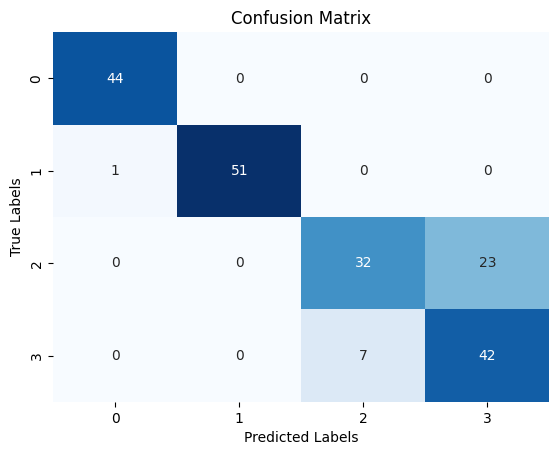

In [26]:
evaluate_classification(y_test, predicted)
plot_confusion_matrix(y_test, predicted)